In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels.stats.api as sms
from scipy.stats import (ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu,
                         pearsonr, spearmanr, kendalltau, f_oneway, kruskal)
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import MultiComparison


In [ ]:
# TODO : Import the Data
from google.colab import files
files.upload()

Saving AB_Test_Results.csv to AB_Test_Results.csv


{'AB_Test_Results.csv': b'USER_ID,VARIANT_NAME,REVENUE\n737,variant,0.0\n2423,control,0.0\n9411,control,0.0\n7311,control,0.0\n6174,variant,0.0\n2380,variant,0.0\n2849,control,0.0\n9168,control,0.0\n6205,variant,0.0\n7548,control,0.0\n8395,control,0.0\n1184,control,0.0\n7165,control,0.0\n2529,variant,2.15\n3489,variant,0.0\n8406,variant,0.0\n7549,variant,0.0\n9085,variant,0.0\n4572,variant,0.0\n8927,variant,0.0\n3383,variant,0.0\n6588,variant,0.0\n6226,variant,0.0\n425,variant,0.0\n4772,variant,0.0\n598,variant,0.0\n3614,variant,0.0\n2667,control,0.0\n3153,control,0.0\n7951,control,0.0\n7257,control,0.0\n3610,control,0.0\n7296,control,0.0\n5599,variant,0.0\n8281,variant,0.0\n2653,control,0.0\n3336,control,0.0\n8275,control,0.0\n6025,variant,0.0\n5171,control,0.0\n4303,control,0.0\n7539,control,0.0\n2073,control,0.0\n8796,control,0.0\n8971,variant,0.0\n4064,control,0.0\n3354,control,0.0\n5142,control,0.0\n1145,variant,0.0\n6429,control,3.25\n9234,variant,0.0\n8976,variant,0.0\n7928,cont

# Data Understanding

In [ ]:
#TODO : compute the following : DataFrame Information, Columns in DataFrame, Counting Missing Values, Descriptive Statistics, Value Counts for VARIANT_NAME, Counting Unique Users in USER_ID
df = pd.read_csv('AB_Test_Results.csv')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [ ]:
df.max()

,0
USER_ID,10000
VARIANT_NAME,variant
REVENUE,196.01


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [ ]:
df['REVENUE'].describe()

,REVENUE
count,10000.000000
mean,0.099447
std,2.318529
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,196.010000


In [ ]:
df.isnull().sum()

,0
USER_ID,0
VARIANT_NAME,0
REVENUE,0


In [ ]:
df['VARIANT_NAME'].value_counts()

,count
VARIANT_NAME,
variant,5016
control,4984


In [ ]:
df['USER_ID'].nunique()

6324

# Average Revenue by VARIANT_NAME

In [ ]:
#TODO
df.groupby('VARIANT_NAME')['REVENUE'].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,4984.0,0.129013,3.007524,0.0,0.0,0.0,0.0,196.01
variant,5016.0,0.070070,1.314802,0.0,0.0,0.0,0.0,58.63


What if H0: M1 = M2 ?
What about H1: M1 1= M2 ?

# Assumptions Control:
*# 1- Normality Assumptions*
*# 2- Homogeneity of Variances Assumption*

In [ ]:
# TODO : test the normality of revenue data in two groups (variant and control) within your DataFrame df using the Shapiro-Wilk test, what can you conclude ?
variant = df[df['VARIANT_NAME'] == 'variant']['REVENUE']
control = df[df['VARIANT_NAME'] == 'control']['REVENUE']

# Perform the Shapiro-Wilk test on variant and control groups
shapiro_test_variant = shapiro(variant)
shapiro_test_control = shapiro(control)

print(f"Shapiro-Wilk Test for Variant Group Revenue: Statistic={shapiro_test_variant.statistic:.4f}, p-value={shapiro_test_variant.pvalue:.4f}")
print(f"Shapiro-Wilk Test for Control Group Revenue: Statistic={shapiro_test_control.statistic:.4f}, p-value={shapiro_test_control.pvalue:.4f}")

# Conclusion based on p-value (common alpha = 0.05)
alpha = 0.05
print("\nConclusion for Normality Test:")
if shapiro_test_variant.pvalue < alpha:
    print("Variant group revenue is NOT normally distributed (p < 0.05).")
else:
    print("Variant group revenue IS normally distributed (p >= 0.05).")

if shapiro_test_control.pvalue < alpha:
    print("Control group revenue is NOT normally distributed (p < 0.05).")
else:
    print("Control group revenue IS normally distributed (p >= 0.05).")

Shapiro-Wilk Test for Variant Group Revenue: Statistic=0.0270, p-value=0.0000
Shapiro-Wilk Test for Control Group Revenue: Statistic=0.0183, p-value=0.0000

Conclusion for Normality Test:
Variant group revenue is NOT normally distributed (p < 0.05).
Control group revenue is NOT normally distributed (p < 0.05).


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5016.
  res = hypotest_fun_out(*samples, **kwds)


The Shapiro-Wilk test for normality shows that both the variant and control groups' revenue distributions are not normal (p-values are 0.0000, which is much less than the significance level of 0.05). This means we cannot assume normality for these datasets. You also received a user warning that the p-value might not be accurate for sample sizes greater than 5000, but even with this warning, the p-values are so small that the conclusion of non-normality is robust.

In [ ]:
# TODO : test for the homogeneity of variances between two groups (variant and control) within your DataFrame df using the Levene's test,  what can you conclude ?
levene_test = levene(variant, control)

print(f"Levene's Test: Statistic={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")

# Conclusion based on p-value (common alpha = 0.05)
alpha = 0.05
print("\nConclusion for Homogeneity of Variances Test:")
if levene_test.pvalue < alpha:
    print("Variances are NOT homogeneous (p < 0.05).")
else:
    print("Variances ARE homogeneous (p >= 0.05).")

Levene's Test: Statistic=1.6159, p-value=0.2037

Conclusion for Homogeneity of Variances Test:
Variances ARE homogeneous (p >= 0.05).


The Levene's Test for homogeneity of variances resulted in a p-value of 0.2037. Since this is greater than our significance level of 0.05, we conclude that the variances of the revenue data between the variant and control groups are homogeneous. This is a good result, but since we previously found that the data is not normally distributed, we will proceed with a non-parametric test.

# Non-Parametric Test (mannwhitneyu Test)

In [ ]:
# TODO : perform the Mann-Whitney U test for comparing the average revenue between the variant and control groups in your DataFrame, what can you conclude ?
mannwhitneyu_test = mannwhitneyu(variant, control)

print(f"Mann-Whitney U Test: Statistic={mannwhitneyu_test.statistic:.4f}, p-value={mannwhitneyu_test.pvalue:.4f}")

# Conclusion based on p-value (common alpha = 0.05)
alpha = 0.05
print("\nConclusion for Mann-Whitney U Test:")
if mannwhitneyu_test.pvalue < alpha:
    print("There is a statistically significant difference in the average revenue between the variant and control groups (p < 0.05).")
else:
    print("There is NO statistically significant difference in the average revenue between the variant and control groups (p >= 0.05).")

Mann-Whitney U Test: Statistic=12478180.0000, p-value=0.4783

Conclusion for Mann-Whitney U Test:
There is NO statistically significant difference in the average revenue between the variant and control groups (p >= 0.05).


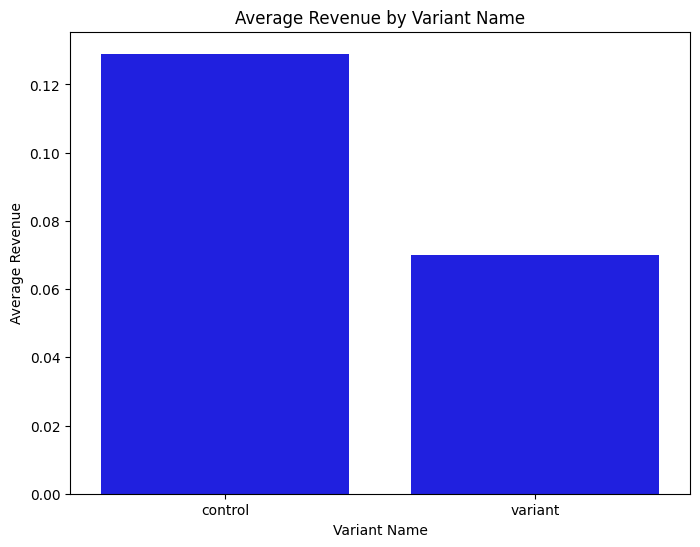

In [ ]:
# TODO : create a bar plot showing the average revenues by variant names using the seaborn library

# Calculate the average revenue for each variant
average_revenue = df.groupby('VARIANT_NAME')['REVENUE'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='VARIANT_NAME', y='REVENUE', data=average_revenue, color='blue')
plt.title('Average Revenue by Variant Name')
plt.xlabel('Variant Name')
plt.ylabel('Average Revenue')
plt.show()